In [1]:
import sys
sys.path.append("../../VAE_GAN")
sys.path.append("../slim")

In [2]:
from variational_autoencoder import VAE
import tensorflow as tf
import time
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

/home/dlipin/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [10]:
checkpoint_folder_path = "model_slim"
checkpoint_path = tf.train.latest_checkpoint(checkpoint_folder_path)
checkpoint_step = int(checkpoint_path.split('-')[1])
batch_size = 64

queues = tf.contrib.slim.queues
with tf.Graph().as_default():
    model = VAE(mode="train", data_path="../data/mnist", z_dim=64)
    model.build()
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        with queues.QueueRunners(sess):
            tf.logging.info("Loading model from checkpoint: %s", checkpoint_path)
            inputs = sess.run(model.inputs)
            model.inputs = tf.Variable(inputs)
            sess.run(tf.global_variables_initializer())
            saver.restore(sess, checkpoint_path)
            tf.logging.info("Successfully loaded checkpoint: %s",
                            os.path.basename(checkpoint_path))
            model.inputs.assign(inputs)
            gray_1d = sess.run(tf.nn.sigmoid(
                model.Decoder(model.sampling_z(*
                    model.Encoder(
                        model.inputs)))))[0]
#             gray_1d = sess.run(tf.nn.sigmoid(model.logits))


The mode is train.
complete initializing model.
complete model build.
INFO:tensorflow:Loading model from checkpoint: model_slim/model.ckpt-100000
INFO:tensorflow:Restoring parameters from model_slim/model.ckpt-100000
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-100000


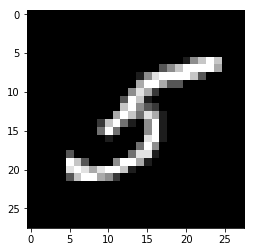

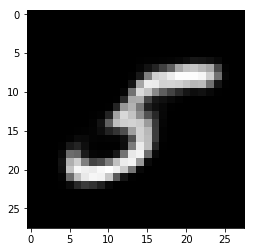

In [14]:
idx = 2

plt.imshow(inputs[idx].reshape(28, 28), cmap='gray')
plt.figure()
plt.imshow(gray_1d[idx].reshape(28, 28), cmap='gray')

In [15]:
gray_1d.mean(axis=1)

array([0.17247231, 0.16529694, 0.08025853, 0.18252991, 0.11923107,
       0.14031796, 0.09899585, 0.11725665, 0.08184824, 0.09604666,
       0.14355183, 0.11437916, 0.0802652 , 0.11168512, 0.12768093,
       0.06248052, 0.10260703, 0.10480853, 0.1762048 , 0.12288141,
       0.09577862, 0.08716523, 0.12730202, 0.07207102, 0.07827289,
       0.05391872, 0.12420153, 0.08304536, 0.09462722, 0.1227266 ,
       0.15171468, 0.07850253, 0.05948865, 0.10908111, 0.15667674,
       0.08510231, 0.12190851, 0.10971861, 0.1272408 , 0.15823595,
       0.2317712 , 0.09375759, 0.1417726 , 0.11655366, 0.16710167,
       0.15146975, 0.12595205, 0.08725545, 0.11219778, 0.11200142,
       0.22660251, 0.04699356, 0.13666852, 0.09856825, 0.1322912 ,
       0.14899816, 0.062095  , 0.15424432, 0.07085469, 0.11456438,
       0.15971573, 0.15686008, 0.09256674, 0.14723848], dtype=float32)

In [6]:
checkpoint_folder_path = "model_slim"
checkpoint_step = -1
batch_size = 64

def run_generator_once(saver, checkpoint_path, model):
    start_time = time.time()
    with tf.Session() as sess:
        tf.logging.info("Loading model from checkpoint: %s", checkpoint_path)
        saver.restore(sess, checkpoint_path)
        tf.logging.info("Successfully loaded checkpoint: %s",
                        os.path.basename(checkpoint_path))

        gray_1d = sess.run(model.X_samples)
        gray_1d *= 255.
        gray_2d = np.reshape(gray_1d, [batch_size, 28, 28])
        color_2d = []
        for i, gray in enumerate(gray_2d):
            color_image = cv2.merge([gray, gray, gray])
            color_image = np.reshape(color_image, [1, 28, 28, 3])
            if i == 0:
                color_2d = color_image
            else:
                color_2d = np.concatenate((color_2d, color_image), axis=0)

        generated_images = color_2d
        print(generated_images.shape)

        duration = time.time() - start_time
        print("Loading time: %.3f" % duration)

    return generated_images

with tf.Graph().as_default():
    start_time = time.time()

    # Build the generative model.
    model = VAE(mode="generate")
    model.build()

#     # Set up the Saver for saving and restoring model checkpoints.
#     saver = tf.train.Saver()

#     if tf.gfile.IsDirectory(checkpoint_folder_path):
#         if checkpoint_step == -1:
#             checkpoint_path = tf.train.latest_checkpoint(checkpoint_folder_path)
#             checkpoint_step = int(checkpoint_path.split('-')[1])
#         else:
#             checkpoint_path = os.path.join(checkpoint_path, 'model.ckpt-%d' % checkpoint_step)
#             checkpoint_step = checkpoint_step

#         if os.path.basename(checkpoint_path) + '.data-00000-of-00001' in os.listdir(checkpoint_folder_path):
#             print(os.path.basename(checkpoint_path))
#         else:
#             raise ValueError("No checkpoint file found in: %s" % checkpoint_path)
#         generated_images = run_generator_once(saver, checkpoint_path, model)
#     else:
#         raise ValueError("checkpoint_path must be folder path")

# # squared_images = make_squared_image(generated_images)


The mode is generate.
complete initializing model.
complete model build.


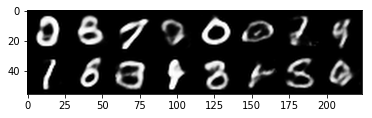

In [14]:
def make_squared_image(generated_images):
    N = len(generated_images)
    black_image = np.zeros(generated_images[0].shape, dtype=np.int32)
    w = int(np.minimum(10, np.sqrt(N)))
    h = int(np.ceil(N / w))

    one_row_image = generated_images[0]
    for j in range(1, w):
        one_row_image = np.concatenate((one_row_image, generated_images[j]), axis=1)

    image = one_row_image
    for i in range(1, h):
        one_row_image = generated_images[i*w]
    for j in range(1, w):
        try:
            one_row_image = np.concatenate((one_row_image, generated_images[i*w + j]), axis=1)
        except:
            one_row_image = np.concatenate((one_row_image, black_image), axis=1)
    image = np.concatenate((image, one_row_image), axis=0)

    return image

image = make_squared_image(generated_images)

plt.imshow(image / 255, interpolation='lanczos')

In [8]:
cv2.imwrite("img.png", image.astype(np.int8))

True

In [14]:
image

array([[[1.4555140e-14, 1.4555140e-14, 1.4555140e-14],
        [1.4670360e-14, 1.4670360e-14, 1.4670360e-14],
        [2.9882984e-14, 2.9882984e-14, 2.9882984e-14],
        ...,
        [2.6121723e-15, 2.6121723e-15, 2.6121723e-15],
        [8.8224442e-16, 8.8224442e-16, 8.8224442e-16],
        [2.2546268e-15, 2.2546268e-15, 2.2546268e-15]],

       [[9.4123216e-15, 9.4123216e-15, 9.4123216e-15],
        [4.9626127e-15, 4.9626127e-15, 4.9626127e-15],
        [4.1267568e-15, 4.1267568e-15, 4.1267568e-15],
        ...,
        [3.9182698e-15, 3.9182698e-15, 3.9182698e-15],
        [1.1668282e-15, 1.1668282e-15, 1.1668282e-15],
        [1.5298051e-15, 1.5298051e-15, 1.5298051e-15]],

       [[1.4420401e-14, 1.4420401e-14, 1.4420401e-14],
        [5.1823365e-15, 5.1823365e-15, 5.1823365e-15],
        [9.3383383e-35, 9.3383383e-35, 9.3383383e-35],
        ...,
        [7.7203145e-20, 7.7203145e-20, 7.7203145e-20],
        [1.0382421e-15, 1.0382421e-15, 1.0382421e-15],
        [9.4022330e-16